# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293
Receiving objects: 100% (6559/6559), 116.26 MiB | 49.62 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [2]:
from pathlib import Path
from PIL import Image
from typing import List, Tuple

import torch
from torch import Tensor,device
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, SGD, AdamW
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights, resnet18, ResNet18_Weights

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

import random
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(45)

In [4]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_dataset = GroceryStoreDataset(split='train',transform=transform)
val_dataset = GroceryStoreDataset(split='val',transform=transform)
test_dataset = GroceryStoreDataset(split='test',transform=transform)
train_dataset.__len__(),val_dataset.__len__(),test_dataset.__len__()

(2640, 296, 2485)

In [ ]:
def check_image_shapes(dataset):
    for i in range(dataset.__len__()):
        img, label = dataset[i]
        w, h = 0,0
        #print(f"Image {i} shape: {img.shape} (width, height)")
        if img.shape[1] > w:
          w = img.shape[1]
        if img.shape[2] > h:
          h = img.shape[2]
    return w,h
# Check shapes of the first few images
w_t,h_t = check_image_shapes(train_dataset)
w_t,h_t
#w_v,h_v = check_image_shapes(val_dataset)
#w_T,h_T = check_image_shapes(test_dataset)

(464, 348)

In [5]:
image_height, image_width, image_channels = 348,348,3
# Define the transform to resize images
resize_transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor()
])

# Load the training dataset with the resizing transform
train_dataset = GroceryStoreDataset(split='train',transform=resize_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Initialize variables to store the mean and std
mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0

# Compute mean and standard deviation
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}')
print(f'Std: {std}')


Mean: tensor([0.5306, 0.3964, 0.2564])
Std: tensor([0.2325, 0.2093, 0.1781])


## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [6]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, epochs, opt, val_dl=None, verbose=False, label_smoothing=0, save_model=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1
    training_values = []
    validation_values = []
    for e in tqdm(range(epochs)):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_dl:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = F.cross_entropy(scores, labels,label_smoothing=label_smoothing)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use

        train_acc /= train_samples
        train_loss /= train_samples
        training_values.append((train_acc,train_loss))

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                for val_data in val_dl:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples
                validation_values.append((val_acc,val_loss))

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e

        if verbose: #and e % 5 == 0:
            print(f"Epoch {e}: train loss {train_loss:.2f} - train acc {train_acc:.2f}" + ("" if val_dl is None else f" - valid loss {val_loss:.2f} - valid acc {val_acc:.2f}"))

            if  save_model and val_acc >= 0.60:
                best_params = model.state_dict()
                torch.save(best_params, "A2.pth")
                best_epoch = e
                break

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc:.2f}")

    return (best_val_acc, best_params, best_epoch,training_values,validation_values)

# CNN

In [7]:
image_height, image_width, image_channels = 348,348,3 #224, 224, 3
num_classes = train_dataset.get_num_classes()

transform_2 = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(image_height, image_width),antialias=True),
    #torchvision.transforms.Resize((image_height, image_width)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
    #torchvision.transforms.Normalize((0.5, 0.4, 0.25), (0.23, 0.2, 0.17))
])

val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_height, image_width)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, std)
    #torchvision.transforms.transforms.Normalize((0.5, 0.4, 0.25), (0.23, 0.2, 0.17))
])
train_dataset = GroceryStoreDataset(split='train',transform=transform_2)
val_dataset = GroceryStoreDataset(split='val',transform=val_transforms)
#test_dataset = GroceryStoreDataset(split='test',transform=transform_2)

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)

In [ ]:
class ExtendedCNN(nn.Module):
    def __init__(self,channels=16, num_classes=num_classes,p_dropout=0):
        super(ExtendedCNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=image_channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels*2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=channels*2, out_channels=channels*4, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=channels*4, out_channels=channels*8, kernel_size=3, stride=1, padding=1)

        # Calculate the size of the feature map after the convolutional layers
        def conv2d_size_out(size, kernel_size=3, stride=1, padding=1):
            return (size - kernel_size + 2 * padding) // stride + 1
        def conv2d_compute_size(conv_number,kernels,max_poolings):  #max pooling ex. [1,0,1] if 1 them there is a max_pool
          image_w = image_width
          for i in range(conv_number):
            image_w = conv2d_size_out(image_w, kernel_size=kernels[i])
            if max_poolings[i] == 1:
              image_w = image_w//2
          return image_w

        #convh = conv2d_size_out(conv2d_size_out(image_height, kernel_size=5, padding=1) // 2, kernel_size=3, padding=1) // 2
        image_w = conv2d_compute_size(4,[3,3,3,3],[1,1,1,1])

        linear_input_size = image_w * image_w * channels*8  # Adjusted based on the output channels of conv2

        # Define fully connected layers
        self.fc1 = nn.Linear(linear_input_size, 128)
        #self.drop1 = nn.Dropout(p_dropout)
        self.fc2 = nn.Linear(128, 64)
        #self.drop2 = nn.Dropout(p_dropout)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        #x = self.drop1(x)
        x = F.relu(self.fc2(x))
        #x = self.drop2(x)
        x = self.fc3(x)

        return x


In [ ]:
new_model = ExtendedCNN(
    num_classes = num_classes,
)
new_model.to(device)

#Training with: weight_decay=0.0, label_smoothing=0.5, lr=0.001, channels=16, batch_size=8

#optimizer = torch.optim.AdamW(new_model.parameters(), lr=0.001,weight_decay=0.01)
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.001)

epochs = 80
label_smoothing = 0.1
best_val_acc, best_params, best_epoch = train_loop(
    new_model,
    train_loader,
    epochs,
    optimizer,
    val_loader,
    verbose=True,
    label_smoothing = label_smoothing,
)

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0: train loss 3.243 - train acc 0.162 - valid loss 3.005 - valid acc 0.186

Epoch 1: train loss 2.826 - train acc 0.243 - valid loss 2.623 - valid acc 0.277

Epoch 2: train loss 2.589 - train acc 0.311 - valid loss 2.867 - valid acc 0.209

Epoch 3: train loss 2.363 - train acc 0.385 - valid loss 2.228 - valid acc 0.294

Epoch 4: train loss 2.179 - train acc 0.447 - valid loss 2.199 - valid acc 0.304

Epoch 5: train loss 2.089 - train acc 0.482 - valid loss 1.878 - valid acc 0.453

Epoch 6: train loss 1.953 - train acc 0.520 - valid loss 2.026 - valid acc 0.389

Epoch 7: train loss 1.878 - train acc 0.556 - valid loss 2.066 - valid acc 0.382

Epoch 8: train loss 1.832 - train acc 0.569 - valid loss 1.845 - valid acc 0.432

Epoch 9: train loss 1.753 - train acc 0.599 - valid loss 1.900 - valid acc 0.429

Epoch 10: train loss 1.714 - train acc 0.616 - valid loss 1.720 - valid acc 0.439

Epoch 11: train loss 1.665 - train acc 0.639 - valid loss 2.097 - valid acc 0.446

Epoch 12: trai

# Part 2

## Function to test model


In [ ]:
def test_plot(model,hyperparameters):

  epochs = hyperparameters['num_epochs']#40
  if hyperparameters['optimizer'] == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])
  elif hyperparameters['optimizer'] == 'AdamW':
      optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd'])
  elif hyperparameters['optimizer'] == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd'])
  # Training
  best_val_acc, best_params, best_epoch,training_values,validation_values = train_loop(
      model,
      train_loader,
      epochs,
      optimizer,
      val_loader,
      verbose=False,
      label_smoothing = hyperparameters['label_smoothing'],
  )
  training_acc = []
  training_loss = []
  #training_values
  validation_acc=[]
  validation_loss=[]
  #validation_values
  for train,val in zip(training_values,validation_values):
    training_acc.append(round(train[0], 2))
    training_loss.append(round(train[1], 2))
    validation_acc.append(round(val[0], 2))
    validation_loss.append(round(val[1], 2))

  print(f"Best epoch {best_epoch}, best acc {best_val_acc:.2f}")
  # Plotting
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

  # Training and validation accuracy
  ax1.plot(training_acc, label='Training Accuracy', marker='o')
  ax1.plot(validation_acc, label='Validation Accuracy', marker='o')
  ax1.set_title('Training and Validation Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend()

  # Training and validation loss
  ax2.plot(training_loss, label='Training Loss', marker='o')
  ax2.plot(validation_loss, label='Validation Loss', marker='o')
  ax2.set_title('Training and Validation Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend()

  # Show the plots
  plt.tight_layout()
  plt.show()

### Using our hyperparameters

In [10]:
hyperparameters = {
    "batch_size": 8,
    "num_epochs": 40,

    "lr": 0.001,
    "optimizer":'Adam',
    "wd": 0,
    "label_smoothing": 0.1
}

  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 37, best acc 0.82


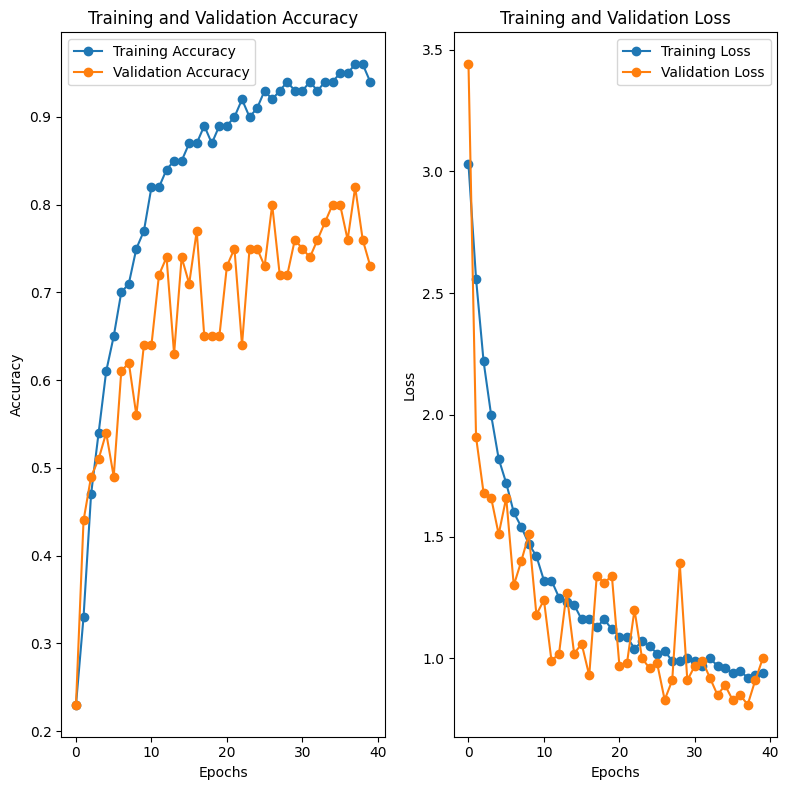

In [ ]:
resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)
test_plot(resnet18,hyperparameters)

### Testing different batch size

Testing with batch_size = 4


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 39, best acc 0.85


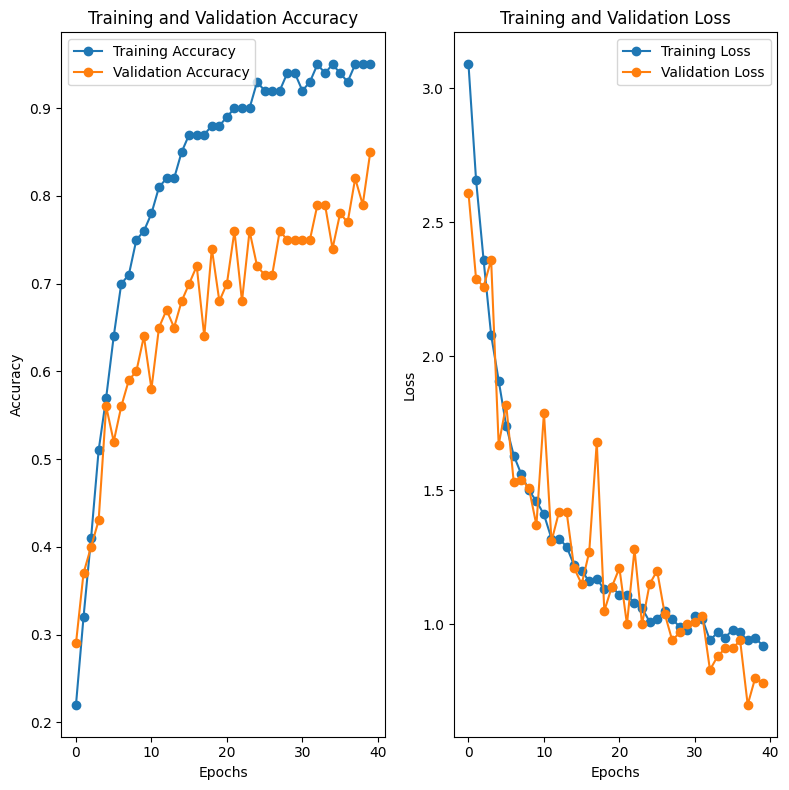

--------------------------------------------------------------------------------
Testing with batch_size = 16


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 39, best acc 0.82


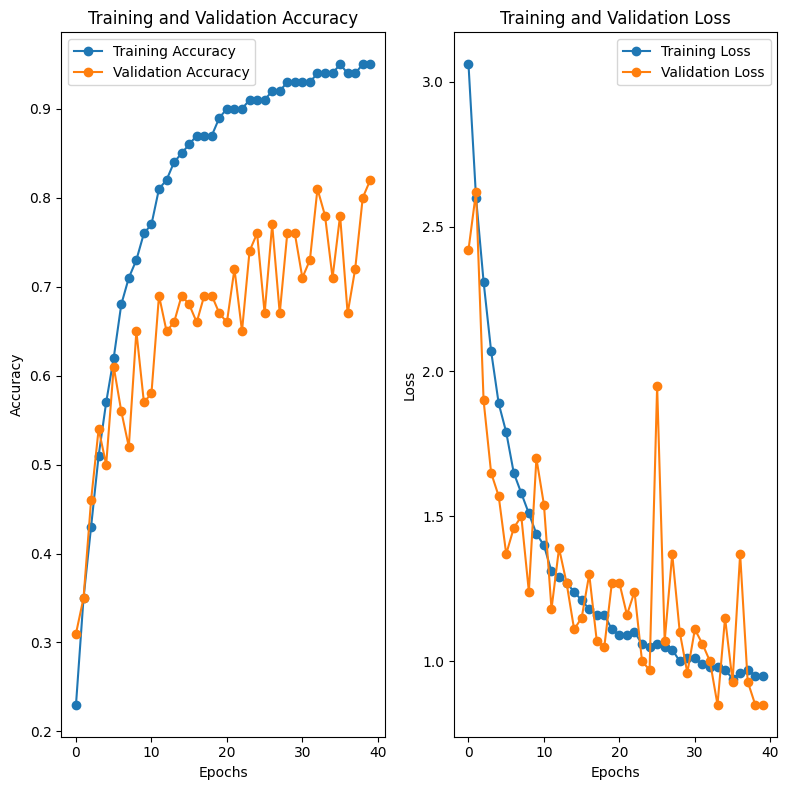

--------------------------------------------------------------------------------
Testing with batch_size = 32


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 34, best acc 0.83


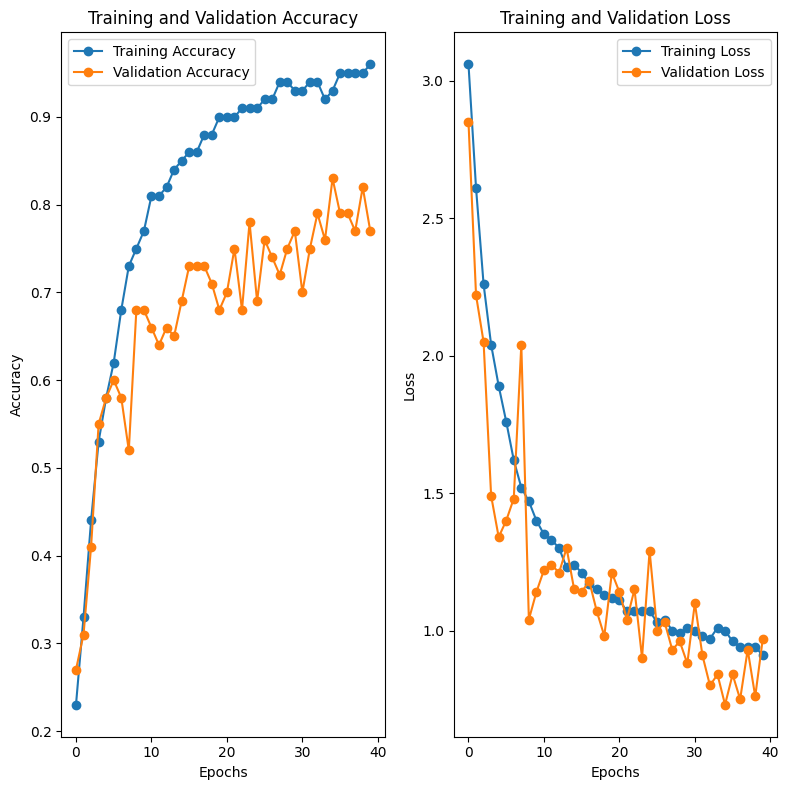

--------------------------------------------------------------------------------


In [ ]:
for batch in [4,16,32]:
  print(f"Testing with batch_size = {batch}")
  hyperparameters['batch_size']=batch
  resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
  resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
  resnet18 = resnet18.to(device)
  test_plot(resnet18,hyperparameters)
  print('-'*80)
hyperparameters['batch_size']=8 #reset to our value

### Testing different learning rates

Testing with learning rate = 0.1


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 39, best acc 0.33


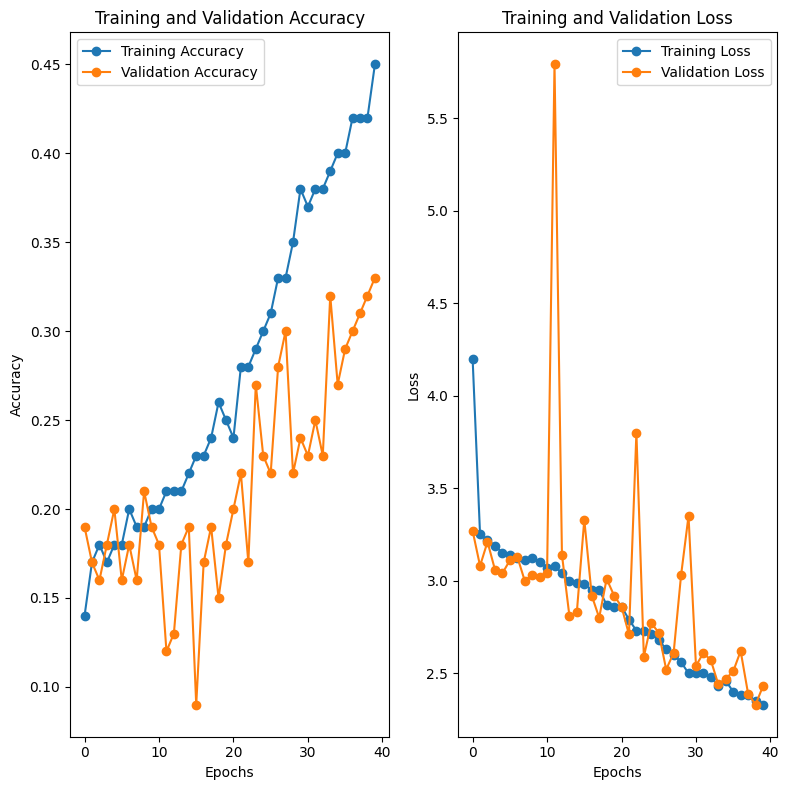

--------------------------------------------------------------------------------
Testing with learning rate = 0.01


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 35, best acc 0.61


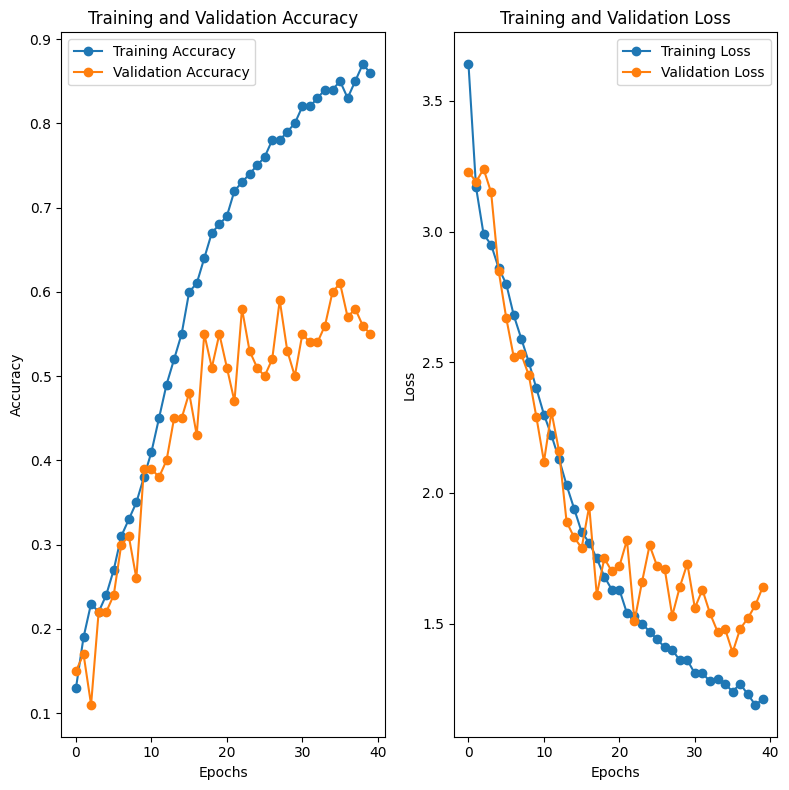

--------------------------------------------------------------------------------


In [ ]:
for lr in [0.1,0.01]:
  print(f"Testing with learning rate = {lr}")
  hyperparameters['lr']=lr
  resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
  resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
  resnet18 = resnet18.to(device)
  test_plot(resnet18,hyperparameters)
  print('-'*80)

hyperparameters['lr']=0.001

### Testing different label smoothing

Testing with label smoothing = 0


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 33, best acc 0.76


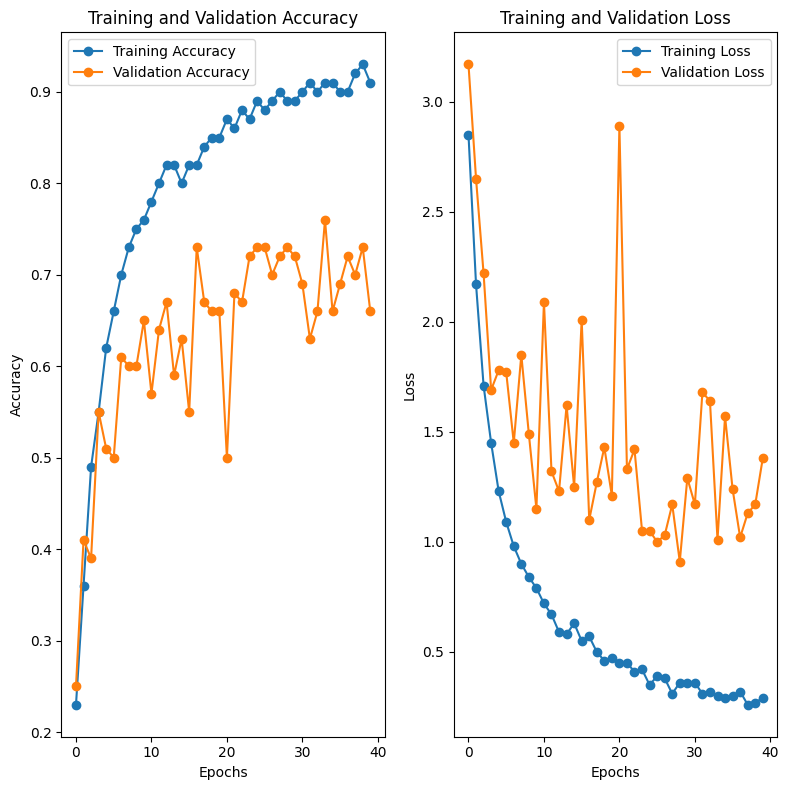

--------------------------------------------------------------------------------
Testing with label smoothing = 0.2


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 39, best acc 0.84


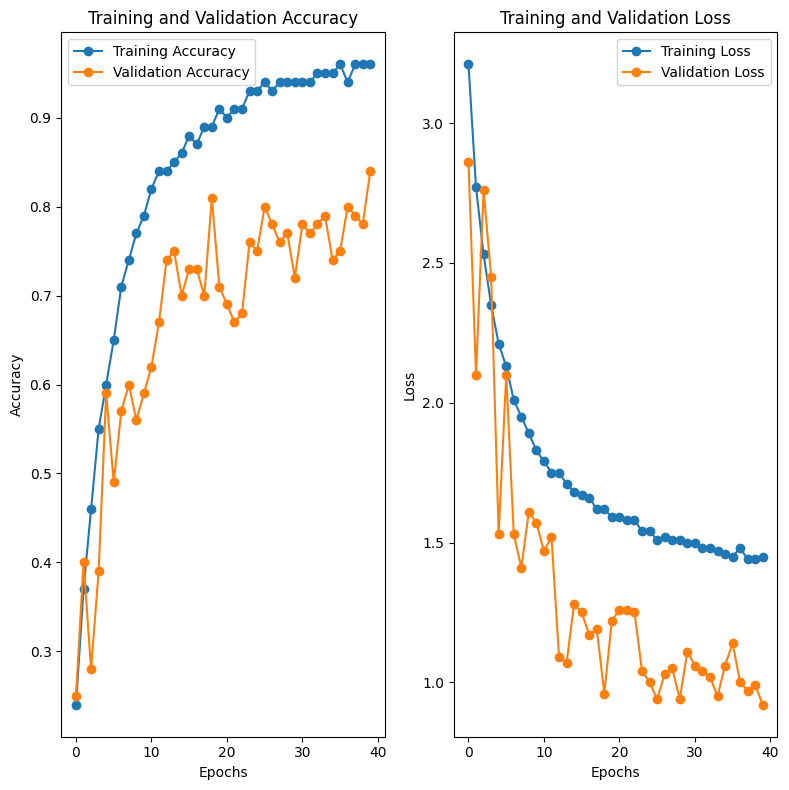

--------------------------------------------------------------------------------


In [ ]:
for ls in [0,0.2]:
  print(f"Testing with label smoothing = {ls}")
  hyperparameters['label_smoothing']=ls

  resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
  resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
  resnet18 = resnet18.to(device)

  test_plot(resnet18,hyperparameters)
  print('-'*80)

hyperparameters['label_smoothing']=0.1

### Testing different optimizers

Testing with SGD and weight decay = 0.01


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 31, best acc 0.92


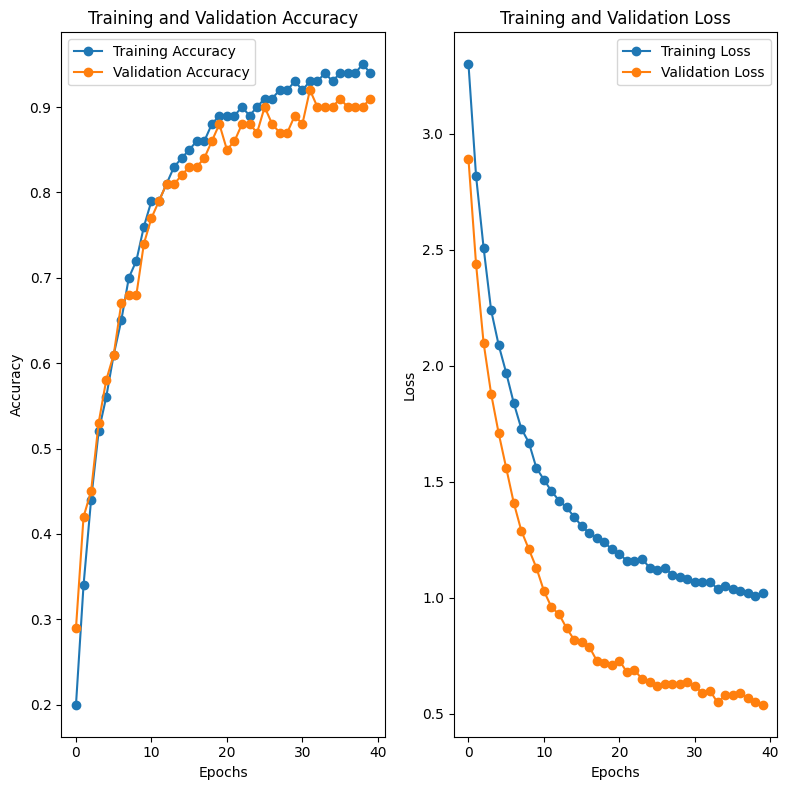

--------------------------------------------------------------------------------
Testing with SGD and weight decay = 0.1


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 35, best acc 0.78


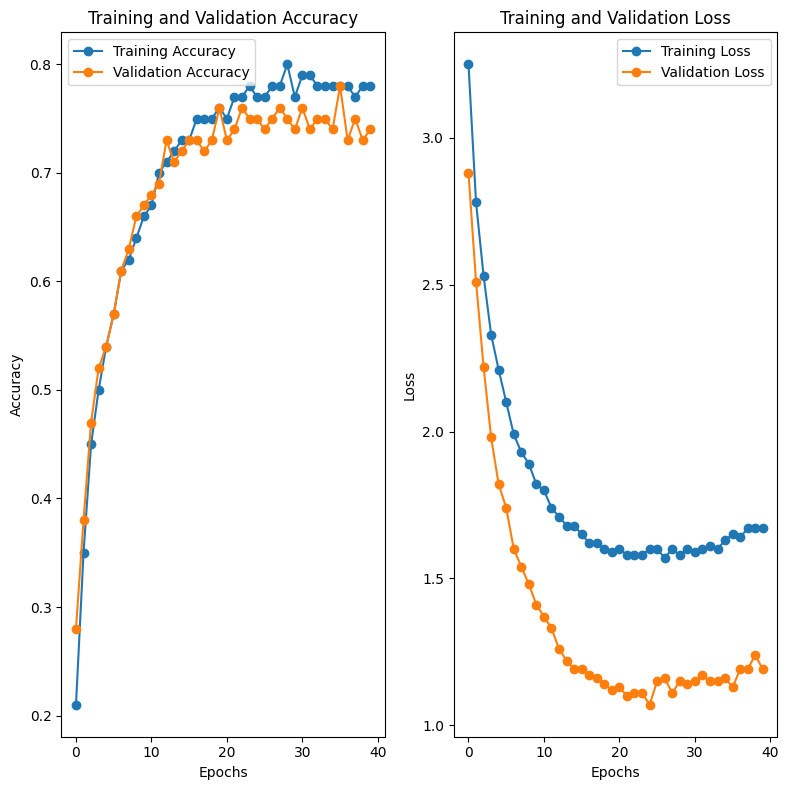

--------------------------------------------------------------------------------


In [ ]:
hyperparameters['optimizer'] = 'SGD'
for wd in [0.01, 0.1]:
  print(f"Testing with SGD and weight decay = {wd}")
  hyperparameters['wd']=wd

  resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
  resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
  resnet18 = resnet18.to(device)

  test_plot(resnet18,hyperparameters)
  print('-'*80)

Testing with AdamW and weight decay = 0.01


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 36, best acc 0.83


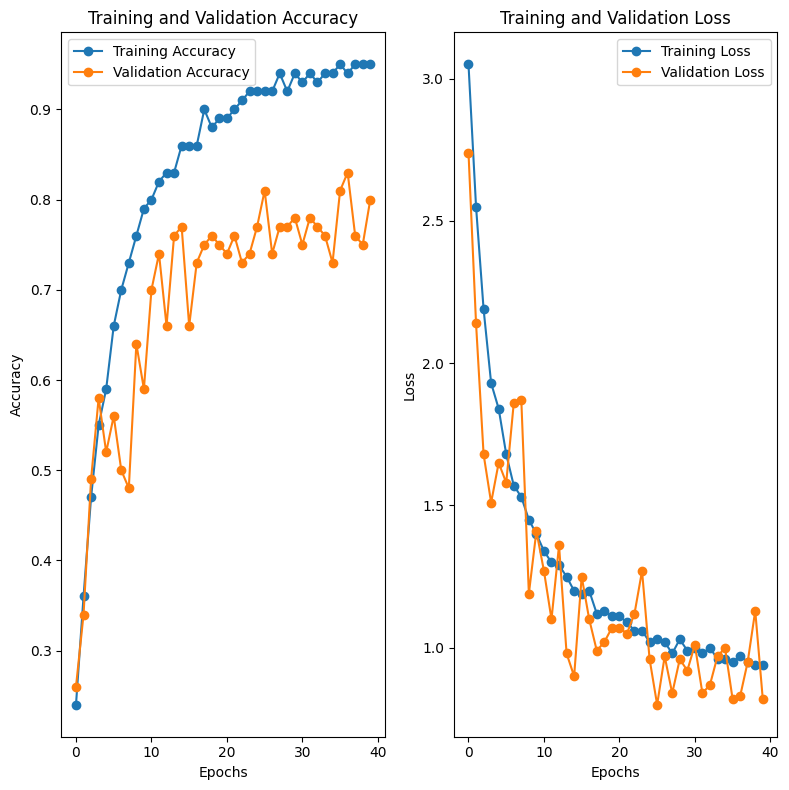

--------------------------------------------------------------------------------
Testing with AdamW and weight decay = 0.1


  0%|          | 0/40 [00:00<?, ?it/s]

Best epoch 38, best acc 0.80


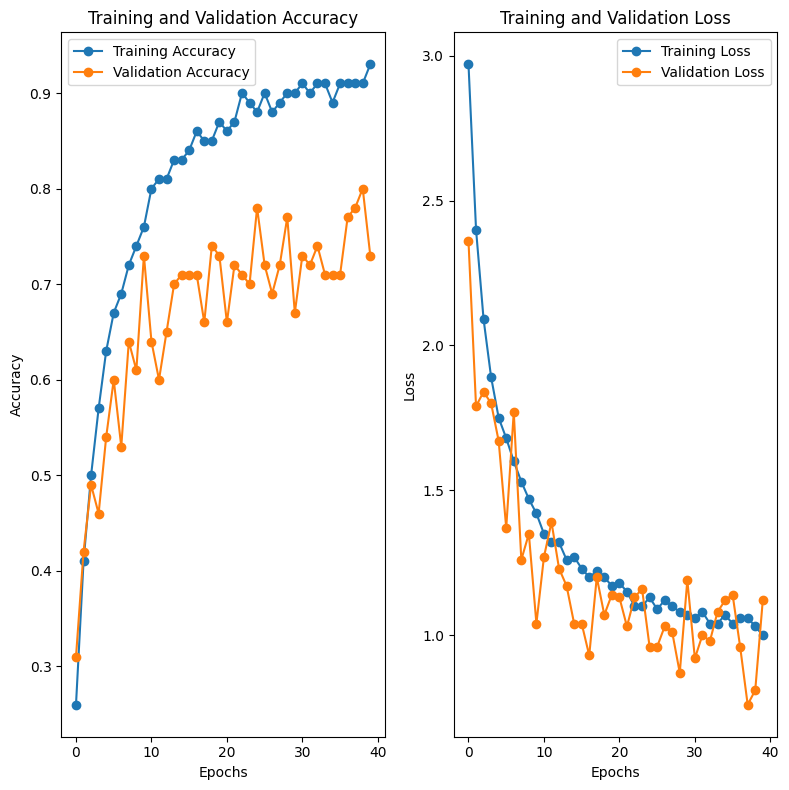

--------------------------------------------------------------------------------


In [ ]:
hyperparameters['optimizer'] = 'AdamW'
for wd in [0.01, 0.1]:
  print(f"Testing with AdamW and weight decay = {wd}")
  hyperparameters['wd']=wd

  resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
  resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
  resnet18 = resnet18.to(device)

  test_plot(resnet18,hyperparameters)
  print('-'*80)
hyperparameters['wd']=0
hyperparameters['optimizer']='Adam'

### Test freezing


In [8]:
def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

In [27]:
def test_plot_fine_tuning(model,hyperparameters):

    set_requires_grad(model.conv1, False)
    set_requires_grad(model.bn1, False)
    set_requires_grad(model.layer1, False)
    set_requires_grad(model.layer2, False)
    set_requires_grad(model.layer3, False)
    set_requires_grad(model.layer4, False)

    epochs = hyperparameters['num_epochs']#40
    if hyperparameters['optimizer'] == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])
    elif hyperparameters['optimizer'] == 'AdamW':
      optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd'])
    elif hyperparameters['optimizer'] == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd'])
    # Training
    best_val_acc, best_params, best_epoch,training_values,validation_values = train_loop(
      model,
      train_loader,
      epochs,
      optimizer,
      val_loader,
      verbose=False,
      label_smoothing = hyperparameters['label_smoothing'],
    )
    
    training_values = training_values[best_epoch:]
    validation_values = validation_values[best_epoch:]


    training_acc = []
    training_loss = []
    #training_values
    validation_acc=[]
    validation_loss=[]

    for train,val in zip(training_values,validation_values):
        training_acc.append(round(train[0], 2))
        training_loss.append(round(train[1], 2))
        validation_acc.append(round(val[0], 2))
        validation_loss.append(round(val[1], 2))

    sd = torch.load("/kaggle/working/best_model.pth")
    model.load_state_dict(sd)

    set_requires_grad(model.conv1, True)
    set_requires_grad(model.bn1, True)
    set_requires_grad(model.layer1, True)
    set_requires_grad(model.layer2, True)
    set_requires_grad(model.layer3, True)
    set_requires_grad(model.layer4, True)


    if hyperparameters['optimizer'] == 'Adam':
      optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr']*0.1)
    elif hyperparameters['optimizer'] == 'AdamW':
      optimizer = torch.optim.AdamW(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd']*0.1)
    elif hyperparameters['optimizer'] == 'SGD':
      optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameters['lr'],weight_decay=hyperparameters['wd']*0.1)

    print('Unfreezing layers')
    best_epoch_old = best_epoch
    best_val_acc, best_params, best_epoch,training_values,validation_values = train_loop(
        model,
        train_loader,
        10,
        optimizer,
        val_loader,
        verbose=False,
        label_smoothing = hyperparameters['label_smoothing'],
    )
    
    for train,val in zip(training_values,validation_values):
        training_acc.append(round(train[0], 2))
        training_loss.append(round(train[1], 2))
        validation_acc.append(round(val[0], 2))
        validation_loss.append(round(val[1], 2))
    
    print(f"Best epoch {best_epoch+best_epoch_old}, best acc {best_val_acc:.2f}")
    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

    # Training and validation accuracy
    ax1.plot(training_acc, label='Training Accuracy', marker='o')
    ax1.plot(validation_acc, label='Validation Accuracy', marker='o')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Training and validation loss
    ax2.plot(training_loss, label='Training Loss', marker='o')
    ax2.plot(validation_loss, label='Validation Loss', marker='o')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

In [20]:
hyperparameters_freezing = {
    "batch_size": 8,
    "num_epochs": 30,

    "lr": 0.001,
    "optimizer":'Adam',
    "wd": 0,
    "label_smoothing": 0.1
}

  0%|          | 0/30 [00:00<?, ?it/s]

Unfreezing layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: train loss 1.25 - train acc 0.86 - valid loss 1.05 - valid acc 0.71
Epoch 1: train loss 1.12 - train acc 0.91 - valid loss 0.93 - valid acc 0.71
Epoch 2: train loss 1.05 - train acc 0.92 - valid loss 0.85 - valid acc 0.75
Epoch 3: train loss 1.02 - train acc 0.93 - valid loss 0.90 - valid acc 0.74
Epoch 4: train loss 0.99 - train acc 0.94 - valid loss 0.92 - valid acc 0.76
Epoch 5: train loss 0.97 - train acc 0.95 - valid loss 0.88 - valid acc 0.77
Epoch 6: train loss 0.93 - train acc 0.96 - valid loss 0.81 - valid acc 0.80
Epoch 7: train loss 0.94 - train acc 0.96 - valid loss 0.81 - valid acc 0.82
Epoch 8: train loss 0.92 - train acc 0.97 - valid loss 0.71 - valid acc 0.84
Epoch 9: train loss 0.92 - train acc 0.97 - valid loss 0.80 - valid acc 0.81
Best epoch 8, best acc 0.84
Best epoch 29, best acc 0.84


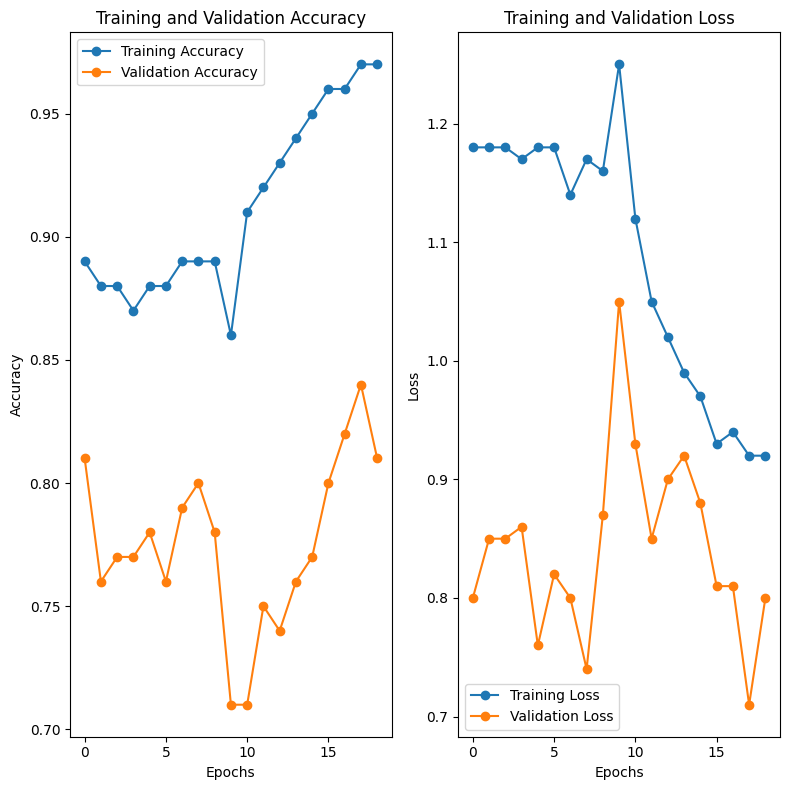

In [23]:
resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18 = resnet18.to(device)

test_plot_fine_tuning(resnet18,hyperparameters_freezing)

  0%|          | 0/30 [00:00<?, ?it/s]

Unfreezing layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: train loss 1.68 - train acc 0.71 - valid loss 1.17 - valid acc 0.70
Epoch 1: train loss 1.54 - train acc 0.77 - valid loss 1.07 - valid acc 0.73
Epoch 2: train loss 1.45 - train acc 0.80 - valid loss 1.00 - valid acc 0.75
Epoch 3: train loss 1.39 - train acc 0.82 - valid loss 0.98 - valid acc 0.75
Epoch 4: train loss 1.35 - train acc 0.84 - valid loss 0.89 - valid acc 0.79
Epoch 5: train loss 1.29 - train acc 0.86 - valid loss 0.82 - valid acc 0.78
Epoch 6: train loss 1.25 - train acc 0.87 - valid loss 0.80 - valid acc 0.81
Epoch 7: train loss 1.25 - train acc 0.88 - valid loss 0.76 - valid acc 0.82
Epoch 8: train loss 1.22 - train acc 0.88 - valid loss 0.72 - valid acc 0.82
Epoch 9: train loss 1.18 - train acc 0.89 - valid loss 0.74 - valid acc 0.80
Best epoch 7, best acc 0.82
Best epoch 33, best acc 0.82


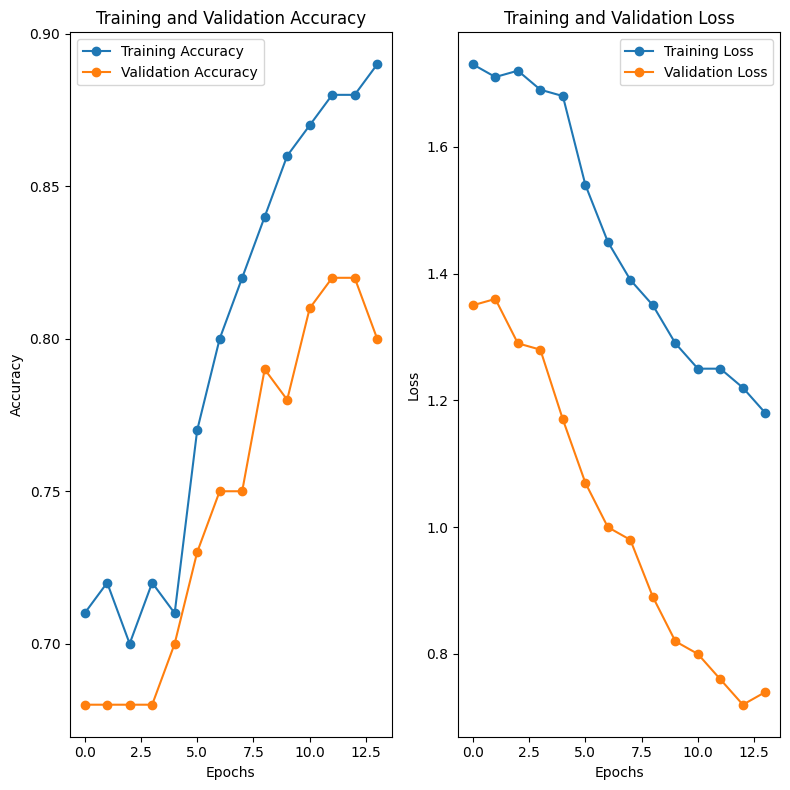

  0%|          | 0/30 [00:00<?, ?it/s]

Unfreezing layers


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: train loss 1.67 - train acc 0.73 - valid loss 1.25 - valid acc 0.66
Epoch 1: train loss 1.53 - train acc 0.77 - valid loss 1.09 - valid acc 0.72
Epoch 2: train loss 1.47 - train acc 0.79 - valid loss 1.04 - valid acc 0.73
Epoch 3: train loss 1.39 - train acc 0.82 - valid loss 0.94 - valid acc 0.78
Epoch 4: train loss 1.35 - train acc 0.83 - valid loss 0.91 - valid acc 0.78
Epoch 5: train loss 1.30 - train acc 0.86 - valid loss 0.88 - valid acc 0.80
Epoch 6: train loss 1.27 - train acc 0.86 - valid loss 0.81 - valid acc 0.80
Epoch 7: train loss 1.24 - train acc 0.88 - valid loss 0.81 - valid acc 0.80
Epoch 8: train loss 1.20 - train acc 0.90 - valid loss 0.75 - valid acc 0.81
Epoch 9: train loss 1.19 - train acc 0.90 - valid loss 0.80 - valid acc 0.81
Best epoch 8, best acc 0.81
Best epoch 33, best acc 0.81


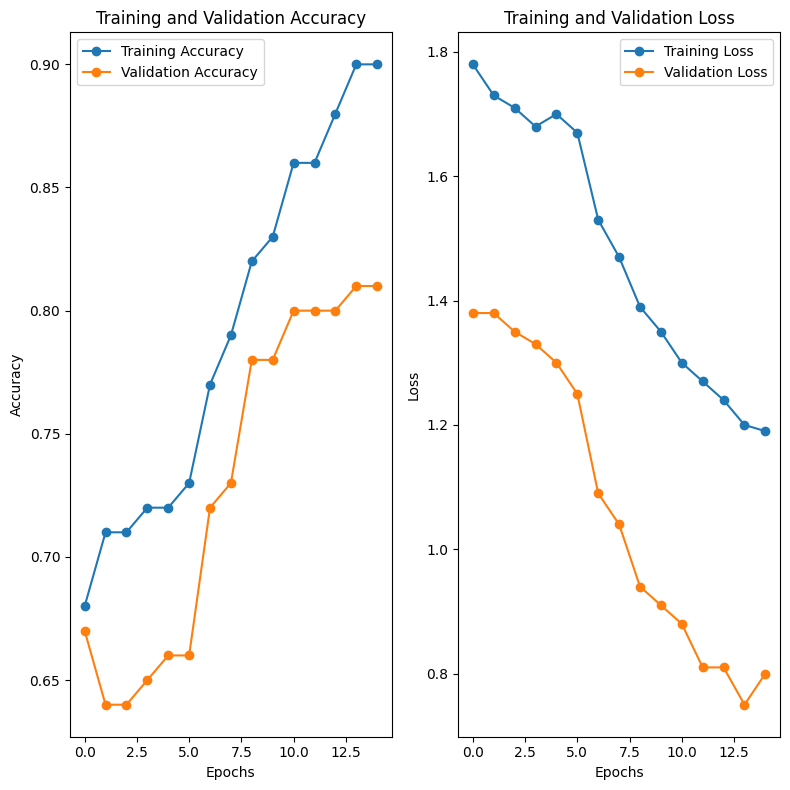

In [25]:
hyperparameters_freezing['optimizer'] = 'SGD'
for wd in [0.01, 0.1]:
    resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    resnet18 = resnet18.to(device)

    test_plot_fine_tuning(resnet18,hyperparameters_freezing)
    

  0%|          | 0/30 [00:00<?, ?it/s]

Unfreezing layers


  0%|          | 0/10 [00:00<?, ?it/s]

Best epoch 30, best acc 0.70


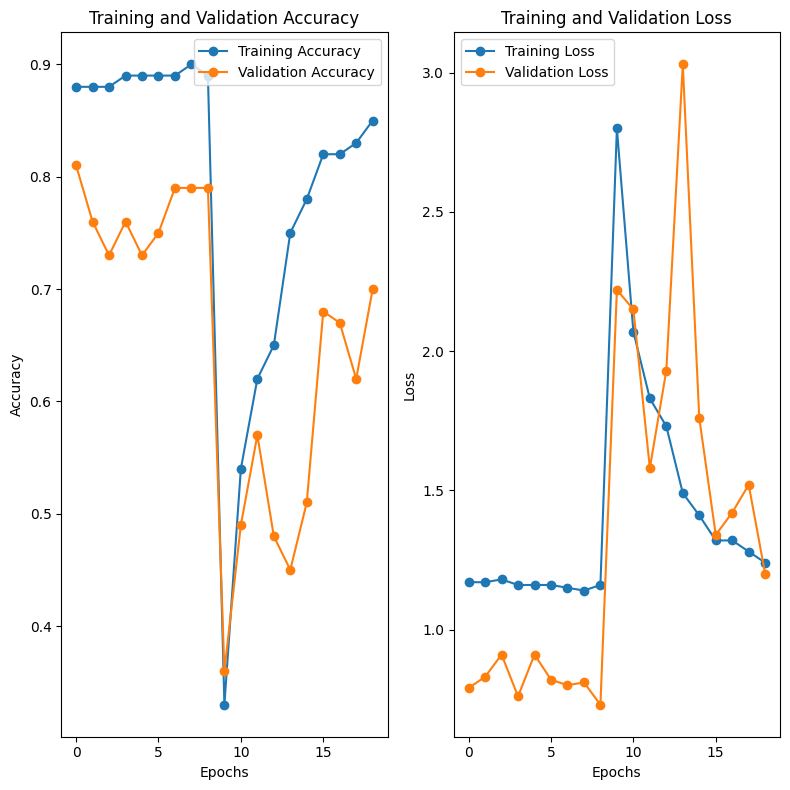

  0%|          | 0/30 [00:00<?, ?it/s]

Unfreezing layers


  0%|          | 0/10 [00:00<?, ?it/s]

Best epoch 28, best acc 0.70


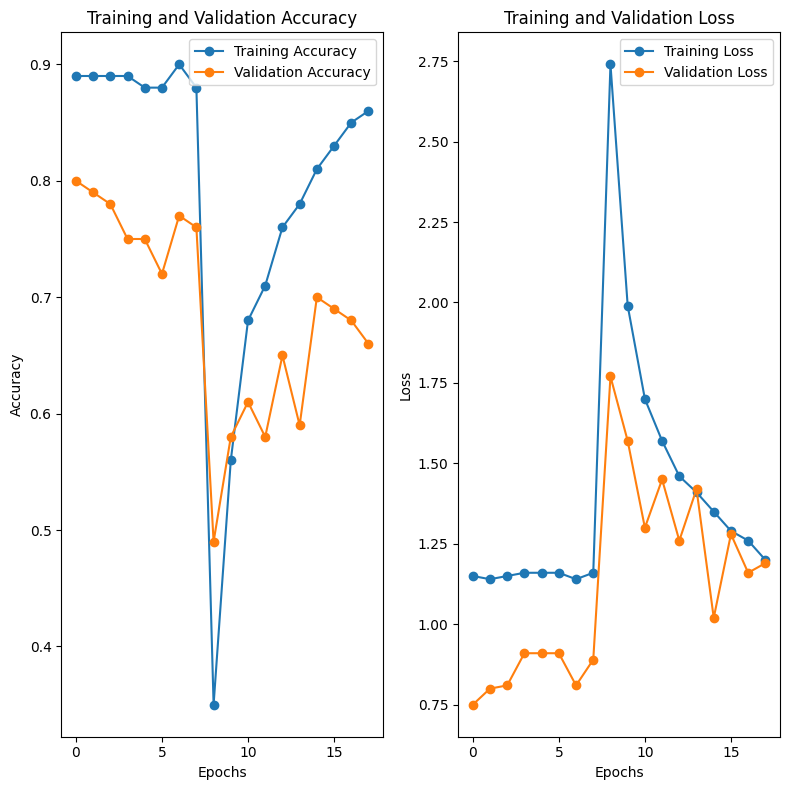

In [28]:
hyperparameters_freezing['optimizer'] = 'AdamW'
for wd in [0.01, 0.1]:
    
    resnet18 = torchvision.models.resnet18(weights= ResNet18_Weights.IMAGENET1K_V1)
    resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
    resnet18 = resnet18.to(device)

    test_plot_fine_tuning(resnet18,hyperparameters_freezing)